# Machine Learning Model ANN

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,10)})
warnings.filterwarnings('ignore')

In [75]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

### Clean Historic and 2022 Data

In [76]:
results = pd.read_csv(r'./data_f1/results.csv')
races = pd.read_csv(r'./data_f1/races.csv')
quali = pd.read_csv(r'./data_f1/qualifying.csv')
drivers = pd.read_csv(r'./data_f1/drivers.csv')
constructors = pd.read_csv(r'./data_f1/constructors.csv')
circuit = pd.read_csv(r'./data_f1/circuits.csv')

In [77]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'], suffixes=('_a', '_b'))
data = df5

In [78]:
#considering data points from 2010
data = data[data['year']>=2010]

In [79]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [80]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [81]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Renault' else x)
# Correction for 2021
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Alpine F1 Team' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [82]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [83]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],axis=1,inplace=True)

In [84]:
historicData = data.drop(data[data.year == 2022].index)
data_2022 = data[data.year == 2022]

In [85]:
historicData.to_csv('./data_f1/ANNData/data_filtered.csv', index = False)
data_2022.to_csv('./data_f1/ANNData/data_filtered_2022.csv', index = False)

### Prepare Historic Data

In [86]:
data = pd.read_csv('./data_f1/ANNData/data_filtered.csv')

In [87]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [88]:
driver_confidence_dict

{'Adrian Sutil': 0.868421052631579,
 'Alexander Albon': 0.972972972972973,
 'Alexander Rossi': 1.0,
 'André Lotterer': 1.0,
 'Antonio Giovinazzi': 0.9180327868852459,
 'Brendon Hartley': 0.88,
 'Bruno Senna': 0.8260869565217391,
 'Carlos Sainz': 0.9142857142857143,
 'Charles Leclerc': 0.8765432098765432,
 'Charles Pic': 0.9487179487179487,
 'Christian Klien': 1.0,
 'Daniel Ricciardo': 0.9521531100478469,
 'Daniil Kvyat': 0.9196428571428571,
 'Esteban Gutiérrez': 0.847457627118644,
 'Esteban Ocon': 0.9431818181818182,
 'Felipe Massa': 0.9161290322580645,
 'Felipe Nasr': 0.925,
 'Fernando Alonso': 0.9333333333333333,
 'George Russell': 0.9166666666666666,
 'Giedo van der Garde': 0.8421052631578947,
 'Heikki Kovalainen': 0.95,
 'Jack Aitken': 1.0,
 'Jaime Alguersuari': 0.9210526315789473,
 'Jarno Trulli': 0.972972972972973,
 'Jean-Éric Vergne': 0.9137931034482758,
 'Jenson Button': 0.9407407407407408,
 'Jolyon Palmer': 0.8571428571428572,
 'Jules Bianchi': 0.9117647058823529,
 "Jérôme d'A

In [89]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_reliability = 1-constructor_dnf_ratio
constructor_reliability_dict = dict(zip(constructor_reliability.index,constructor_reliability))

In [90]:
constructor_reliability_dict

{'Alfa Romeo': 0.41276595744680855,
 'AlphaTauri': 0.47558386411889597,
 'Alpine F1': 0.5340425531914894,
 'Aston Martin': 0.6088794926004228,
 'Caterham': 0.1785714285714286,
 'Ferrari': 0.8776371308016877,
 'HRT': 0.15652173913043477,
 'Haas F1 Team': 0.345679012345679,
 'Lotus': 0.07894736842105265,
 'Manor Marussia': 0.12121212121212122,
 'Marussia': 0.16666666666666663,
 'McLaren': 0.6093418259023354,
 'Mercedes': 0.8879492600422833,
 'Red Bull': 0.836864406779661,
 'Virgin': 0.09210526315789469,
 'Williams': 0.4820295983086681}

In [91]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_reliability'] = data['constructor'].apply(lambda x:constructor_reliability_dict[x])
#removing retired drivers and constructors
active_constructors = constructor_reliability_dict.keys()
active_drivers = driver_confidence.index
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [92]:
cleaned_data = data[['position', 'active_constructor', 'active_driver', 'GP_name','constructor','driver', 'quali_pos', 'positionOrder', 'points', 'constructor_reliability', 'year', 'round', 'driver_confidence', 'number_x', 'lat']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('./data_f1/ANNData/cleaned_data.csv',index=False)

### Prepare 2022 data

In [93]:
data = pd.read_csv('./data_f1/ANNData/data_filtered_2022.csv')

In [94]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [95]:
driver_confidence_dict

{'Alexander Albon': 0.8571428571428572,
 'Carlos Sainz': 0.8181818181818181,
 'Charles Leclerc': 0.9545454545454546,
 'Daniel Ricciardo': 0.9545454545454546,
 'Esteban Ocon': 1.0,
 'Fernando Alonso': 0.9545454545454546,
 'George Russell': 0.9545454545454546,
 'Guanyu Zhou': 0.9090909090909091,
 'Kevin Magnussen': 0.9090909090909091,
 'Lance Stroll': 0.9545454545454546,
 'Lando Norris': 0.9545454545454546,
 'Lewis Hamilton': 0.9545454545454546,
 'Max Verstappen': 1.0,
 'Mick Schumacher': 0.9545454545454546,
 'Nicholas Latifi': 0.8181818181818181,
 'Nico Hülkenberg': 1.0,
 'Nyck de Vries': 1.0,
 'Pierre Gasly': 0.9545454545454546,
 'Sebastian Vettel': 0.9,
 'Sergio Pérez': 0.9545454545454546,
 'Valtteri Bottas': 0.9090909090909091,
 'Yuki Tsunoda': 0.8636363636363636}

In [96]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_reliability = 1-constructor_dnf_ratio
constructor_reliability_dict = dict(zip(constructor_reliability.index,constructor_reliability))

In [97]:
constructor_reliability_dict

{'Alfa Romeo': 0.5681818181818181,
 'AlphaTauri': 0.5681818181818181,
 'Alpine F1': 0.6818181818181819,
 'Aston Martin': 0.7045454545454546,
 'Ferrari': 0.9090909090909091,
 'Haas F1 Team': 0.4772727272727273,
 'McLaren': 0.7727272727272727,
 'Mercedes': 0.9318181818181819,
 'Red Bull': 0.9090909090909091,
 'Williams': 0.5454545454545454}

In [98]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_reliability'] = data['constructor'].apply(lambda x:constructor_reliability_dict[x])
#removing retired drivers and constructors
active_constructors = constructor_reliability_dict.keys()
active_drivers = driver_confidence.index
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [99]:
cleaned_data = data[['position', 'active_constructor', 'active_driver', 'GP_name','constructor','driver', 'quali_pos', 'positionOrder', 'points', 'constructor_reliability', 'year', 'round', 'driver_confidence', 'number_x', 'lat']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('./data_f1/ANNData/cleaned_data_2022.csv',index=False)

### Prepare Data for Training

In [100]:
x_train = pd.read_csv('./data_f1/ANNData/cleaned_data.csv')
x_test = pd.read_csv('./data_f1/ANNData/cleaned_data_2022.csv')

In [101]:
x_train = x_train[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]
x_test = x_test[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]

In [102]:
x_train = x_train[x_train['active_constructor']==1]
x_train = x_train[x_train['active_driver']==1]

x_test = x_test[x_test['active_constructor']==1]
x_test = x_test[x_test['active_driver']==1]

In [103]:
sc  = StandardScaler()
le = LabelEncoder()

x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
x_train['constructor'] = le.fit_transform(x_train['constructor'])
x_train['driver'] = le.fit_transform(x_train['driver'])
x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
X_train = x_train.drop(['position','active_driver','active_constructor'],1)
y_train = x_train['position'].apply(lambda x: position_index(x))

x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
x_test['constructor'] = le.fit_transform(x_test['constructor'])
x_test['driver'] = le.fit_transform(x_test['driver'])
x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
X_test = x_test.drop(['position','active_driver','active_constructor'],1)
y_test = x_test['position'].apply(lambda x: position_index(x))

In [104]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

### Create and train model

In [105]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(6,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [106]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                224       
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 3,988
Trainable params: 3,988
Non-traina

In [107]:
opt = optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [108]:
callback_list = [
       tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=7,
            restore_best_weights=True,
            verbose=1
       )         
]

In [109]:
res = model.fit(x=X_train, 
                y=y_train, 
                epochs=50,
                validation_split=0.2,
                callbacks=callback_list)

Epoch 1/50
127/127 [==============================] - 1s 4ms/step - loss: 0.4804 - accuracy: 0.7972 - val_loss: 0.7310 - val_accuracy: 0.6759
Epoch 2/50
127/127 [==============================] - 0s 2ms/step - loss: 0.3777 - accuracy: 0.8545 - val_loss: 0.3491 - val_accuracy: 0.8910
Epoch 3/50
127/127 [==============================] - 0s 2ms/step - loss: 0.3014 - accuracy: 0.8934 - val_loss: 0.3534 - val_accuracy: 0.8702
Epoch 4/50
127/127 [==============================] - 0s 2ms/step - loss: 0.2914 - accuracy: 0.9003 - val_loss: 0.2834 - val_accuracy: 0.9237
Epoch 5/50
127/127 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.9127 - val_loss: 0.3811 - val_accuracy: 0.8434
Epoch 6/50
127/127 [==============================] - 0s 2ms/step - loss: 0.2519 - accuracy: 0.9182 - val_loss: 0.3101 - val_accuracy: 0.9068
Epoch 7/50
127/127 [==============================] - 0s 2ms/step - loss: 0.2885 - accuracy: 0.8984 - val_loss: 0.2926 - val_accuracy: 0.9108
Epoch 

In [110]:
df = pd.DataFrame(res.history)
df

,loss,accuracy,val_loss,val_accuracy
0,0.480405,0.797224,0.730986,0.675917
1,0.377667,0.854487,0.349135,0.890981
2,0.301385,0.893406,0.353362,0.870169
3,0.291441,0.900347,0.283386,0.923687
4,0.267944,0.912742,0.381131,0.843409
5,0.251918,0.918195,0.310057,0.906838
6,0.288495,0.898364,0.292612,0.910803
7,0.246109,0.923153,0.263743,0.928642
8,0.248673,0.920674,0.268759,0.927651
9,0.248252,0.918691,0.271723,0.922696


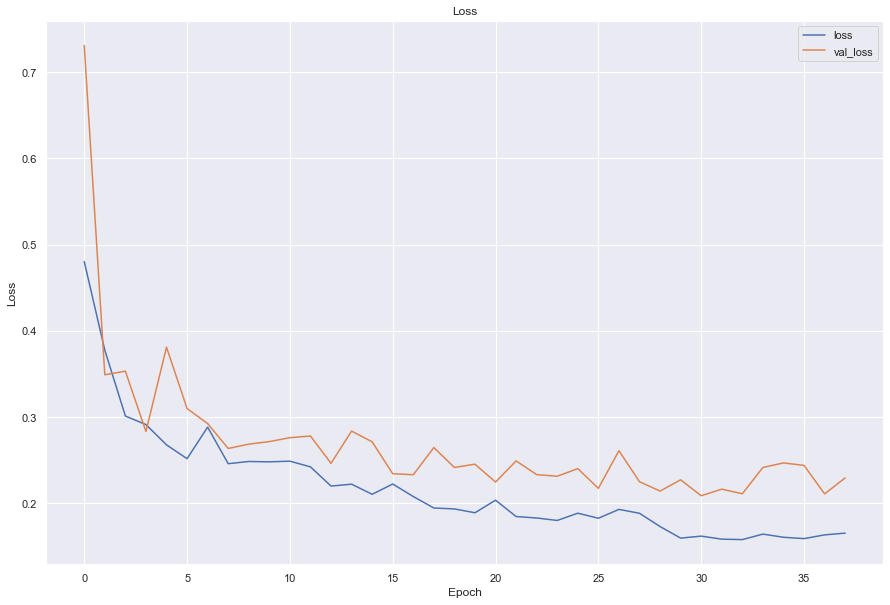

In [111]:
plt.plot(res.epoch, df.loss, label='loss')
plt.plot(res.epoch, df.val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

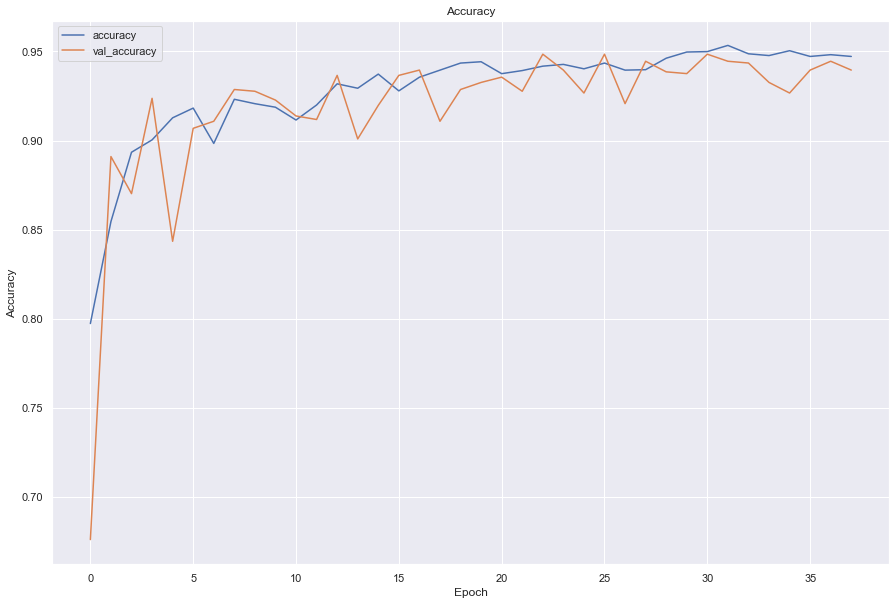

In [112]:
plt.plot(res.epoch, df.accuracy, label='accuracy')
plt.plot(res.epoch, df.val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [113]:
pred = model.predict(X_test)
pred = np.argmax(pred,1)
print('Misclassified examples: %d' % (y_test != pred).sum())

14/14 [==============================] - 0s 1ms/step
Misclassified examples: 60


In [114]:
# Evaluate model
(test_loss, test_accuracy) = model.evaluate(x=X_test,y=y_test)
print("Loss:", test_loss)
print('Accuracy', test_accuracy)

14/14 [==============================] - 0s 1ms/step - loss: 0.5649 - accuracy: 0.8636
Loss: 0.564919650554657
Accuracy 0.8636363744735718


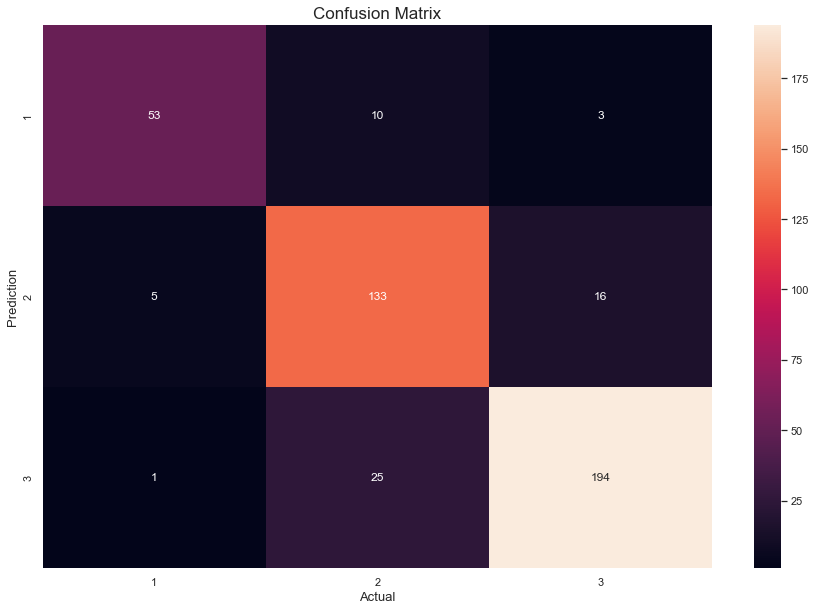

In [115]:
cm = confusion_matrix(y_test,pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['1','2','3'], yticklabels=['1','2','3'])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [116]:
# save model
# path='./web/model/model.h5'
# model.save(path)